# 自作ガウシアン

In [29]:
def gauss(x, a, mu, si, noisef=nf):
    """
    a: 最大値
    mu: 位置
    si: 線幅
    noisef: 最低値
    """
    return a * np.exp(-(x - mu)**2 / 2 / si**2) + noisef

In [30]:
nf=0.5
n=1001
x = np.linspace(0,100,n)
a, mu, si = 1, 50, 1

In [32]:
g= gauss(x, a, mu, si); g

array([ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5])

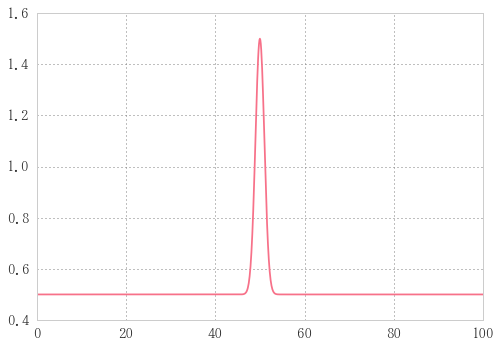

In [33]:
plt.plot(x, g)

## 自作ガウシアンじゃなくてscipy.stats.normを使うべきでは

In [34]:
from  scipy.stats import norm

In [35]:
z=norm.pdf(x, loc=50, scale=1)-0.5; z

array([-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5])

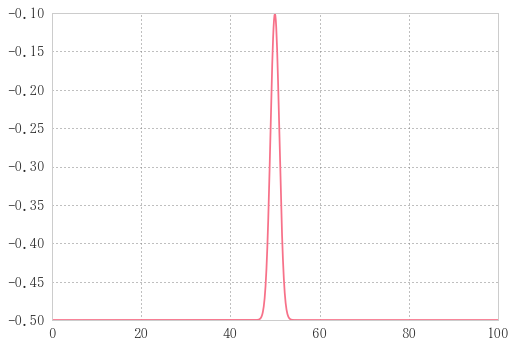

In [36]:
plt.plot(x,z)

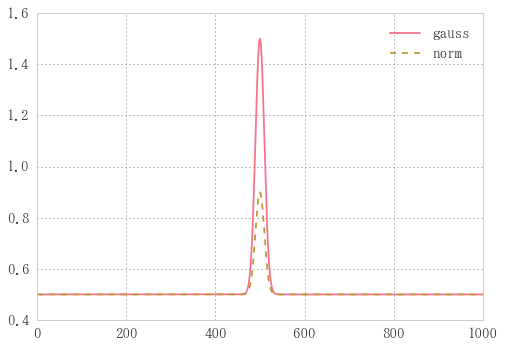

In [37]:
a, mu, si=1, 50, 1
df=pd.DataFrame({'norm': a*norm.pdf(x, loc=mu, scale=si)+nf,
                 			'gauss': gauss(x, a, mu, si, nf)})
df.plot(style=['-', '--'])

## norm vs my_gauss
normでも自作gaussでも中でnp使っているんで実行速度あんま変わらないだろうとテスト

In [38]:
%timeit gauss(x, a, mu, si)

The slowest run took 5.79 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 59.8 µs per loop


In [21]:
%timeit norm.pdf(x, loc=50, scale=1)-0.5

The slowest run took 5.26 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 218 µs per loop


自作ガウスのほうが早い…！

## ガウシアンに沿ってノイズを作る

ということで自作のガウシアンを使っていきます。

In [39]:
g = gauss(x, a, mu, si)
gnoise = g + 0.1 * np.random.randn(n)

ノイズを発生させる

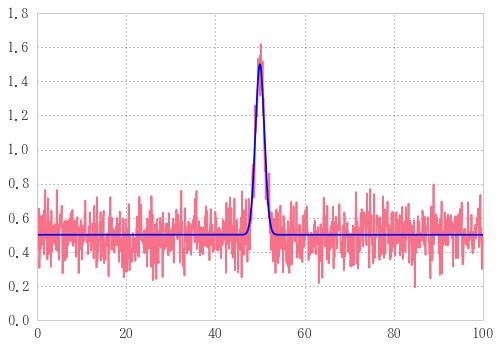

In [40]:
plt.plot(x, gnoise, '-')
plt.plot(x, g,'b-' )

## カーブフィッティングをかけて、ノイズをフィッティングする

gからgnoiseを導き出したのだけれども、ここで急にgを未知の関数とみなしてしまう。
今あなたはgnoiseだけを知っていて、gのような関数を得たいとき、どうするか。

こういう時はカーブフィットを取る。
scipy.optimizeからcurve_fitをインポートしてくる。

In [41]:
from scipy.optimize import curve_fit

<div class="mark">
次にフィッティングパラメータを定める。</div><i class="fa fa-lightbulb-o "></i>

In [113]:
(a_, mu_, si_), _ = curve_fit(gauss, x, gnoise, p0=(a, mu, si))
yfit = gauss(x, a_, mu_, si_)  # フィッティングにより導き出されたa,mu,siを代入
print('元パラメータ:%s\nフィッティングで求めたパラメータ: %s' % ((a, mu , si), (a_, mu_, si_)))

元パラメータ:(1, 50, 1)
フィッティングで求めたパラメータ: (0.98497122782178148, 49.973664385975219, 0.97612666304535545)


In [46]:
_

array([[  8.87235438e-04,   4.49809686e-10,  -5.86253148e-04],
       [  4.49809686e-10,   1.16212476e-03,  -4.46876918e-10],
       [ -5.86253148e-04,  -4.46876918e-10,   1.16212476e-03]])

curve_fitの戻り値アンダーバーは共分散？

    pcov : 2d array
    The estimated covariance of popt. The diagonals provide the variance
    of the parameter estimate. To compute one standard deviation errors
    on the parameters use ``perr = np.sqrt(np.diag(pcov))``.

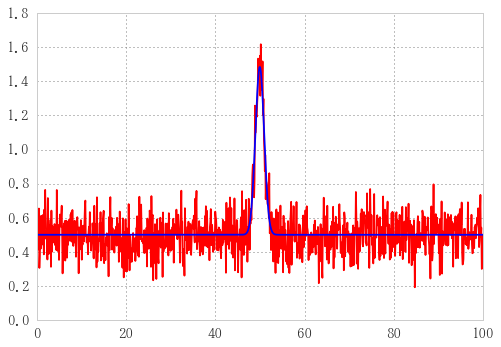

In [48]:
plt.plot(x, gnoise, 'r-')
plt.plot(x, yfit, 'b-') 

さっきと同じグラフに見えるが、描いているのはgではなくyfitであることに注意

同じグラフに見えるということはフィッティングできたということ。

# scipy.stats.normを使った場合

## ガウシアンに沿ってノイズを作る

In [19]:
from  scipy.stats import norm

In [53]:
n=1001
xx = np.linspace(0,100,n)
aa, mu, si = 5, 50, 1

In [57]:
def gauss2(x, a, mu, si):
    return a*norm.pdf(x, loc=mu, scale=si)-noisef

In [58]:
g = gauss2(xx, aa, mu, si)
gnoise = g + 0.1 * np.random.randn(n)

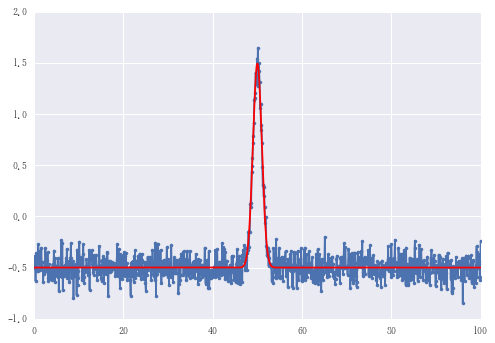

In [59]:
plt.plot(xx, gnoise, '.-')
plt.plot(xx, g,'r-' )

## カーブフィッティングをかけて、ノイズをフィッティングする

gからgnoiseを導き出したのだけれども、ここで急にgを未知の関数とみなしてしまう。
今あなたはgnoiseだけを知っていて、gのような関数を得たいとき、どうするか。

In [66]:
from scipy.optimize import curve_fit
(aa_, mu_, si_), _ = curve_fit(gauss2, xx, gnoise, (aa, mu, si))
yfit = gauss2(xx,aa_, mu_, si_)

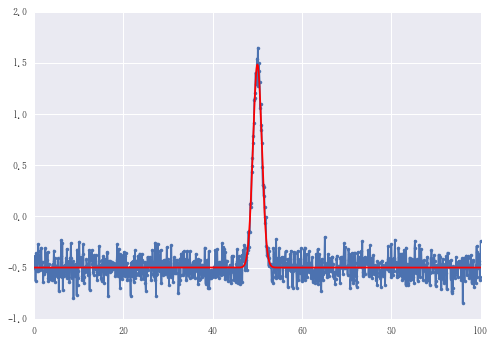

In [67]:
plt.plot(xx, gnoise, '.-')
plt.plot(xx, yfit, 'r-')  # 描いているのはgではなく、yfitであることに注意

ちゃんとフィッティングできた。

# 自作ガウスをノイズのあるデータフレームにcarve_fitをapply

## ランダムデータフレームの作成

In [50]:
r=np.random

いっぱい使うから乱数生成をrに縮めちゃう

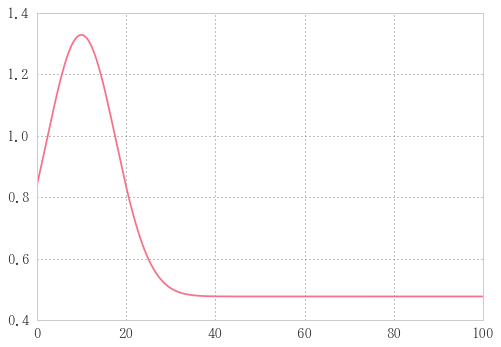

In [79]:
g = gauss(x, a=r.rand(), mu=10*1, si=10*r.rand(), noisef=nf*r.rand())
plt.plot(x, g)

ランダムな値を使って発生させたガウシアン

In [84]:
%%timeit
df = pd.DataFrame([], index=range(1000))
for i in np.arange(min(x), max(x), 10):
    g = gauss(x, a=r.rand(), mu=i, si=10*r.rand(), noisef=nf)
    df[i] = pd.DataFrame(g)

100 loops, best of 3: 9.79 ms per loop


まず思いつくforループ

In [85]:
# %%timeit
garray = np.array([gauss(x, a=r.rand(), mu=i, si=10*r.rand(), noisef=nf)
for i in np.arange(min(x), max(x), 10)]).T
df = pd.DataFrame(garray)

1000 loops, best of 3: 903 µs per loop


より高速

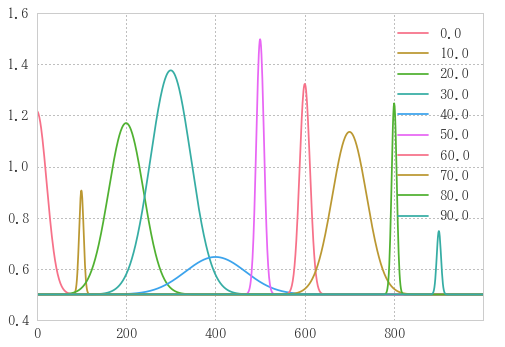

In [86]:
df.plot()

様々な形のガウシアン。

ノイズフロアは一定にした。

こいつらにノイズを載せる。

## ランダムデータフレームにノイズのせてサンプルデータ作成

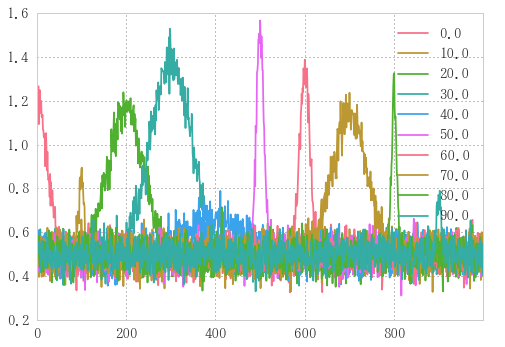

In [226]:
noisedf =df +0.05 * r.randn(*df.shape)
noisedf.plot()

5%のノイズをのせた。
`np.randn(*df.shape)`でデータフレームと同じ行列を持ったランダムデータフレームを生成させている。
スターを`df.shape`の前につけてタプルを展開して`randn`に渡す。

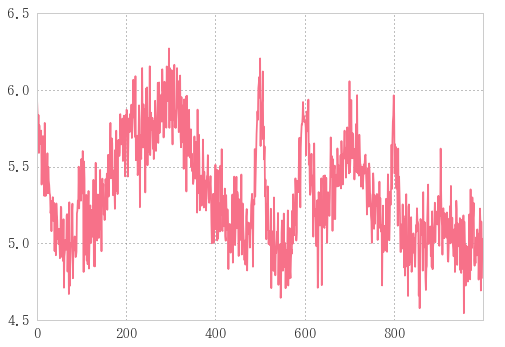

In [228]:
sumdf = noisedf.sum(axis=1)
sumdf.plot()

In [227]:
sumdf

0      5.787823
1      5.844201
2      5.649158
3      5.858712
4      5.649082
5      5.668082
6      5.721880
7      5.799648
8      5.643667
9      5.843835
10     5.935265
11     5.720044
12     5.537058
13     5.245885
14     5.396977
15     5.686164
16     5.774004
17     5.474217
18     5.496124
19     5.355029
20     5.472915
21     5.758243
22     5.176296
23     5.487734
24     5.199490
25     5.571278
26     5.347202
27     5.515283
28     5.239639
29     5.127778
         ...   
970    4.709422
971    4.774488
972    4.734391
973    4.689422
974    4.957229
975    4.956173
976    5.091661
977    5.185160
978    5.149931
979    4.915803
980    4.890884
981    4.914116
982    4.896102
983    4.671823
984    5.210647
985    4.948862
986    5.148135
987    4.834577
988    4.759693
989    4.788015
990    5.038984
991    4.975161
992    4.707990
993    4.899676
994    4.976002
995    5.209907
996    4.702604
997    4.819293
998    5.090502
999    4.725422
dtype: float64

indexはそのままにカラムをすべて足す。この中でindexいくつの位置にガウシアンが立つかを調べる。

# データフレームに一斉にフィッティングかける
一番やりたかったこと　ここから。

In [242]:
param = (a, mu, si) = 5, 300, 3
param

(5, 300, 3)

パラメータ再設定

## 試しに波を一つ選んでfitting

In [254]:
def choice(array, center, span):
    """特定の範囲を抜き出す
    引数: 
        array: 抜き出し対象のarrayっぽいの(arraylike)
        center: 抜き出し中央(float)
        span: 抜き出しスパン(float)
    戻り値:
        rarray:
    """
    x1 = int(center - span / 2)
    x2 = int(center + span / 2)
    return array[x1:x2]

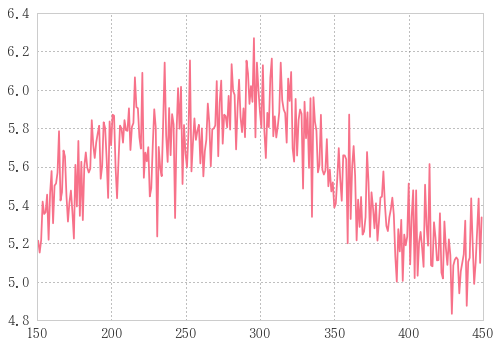

In [256]:
ch = (300, 300)  # 中央値300でスパン300で取り出したい
fitx, fity = choice(sumdf.index, *ch), choice(sumdf, *ch)
plt.plot(fitx, fity)

In [275]:
popt, _pcov = curve_fit(gauss, fitx, fity, p0=param)
print('a, mu, si = ', popt)

a, mu, si =  [   5.33304014  272.51733965  288.27265293]


fittingの結果

In [274]:
gg = gauss(sumdf.index,*popt)

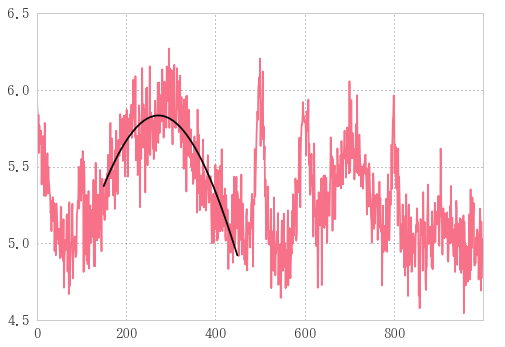

In [273]:
sumdf.plot()
plt.plot(fitx, choice(gg, *ch), 'k-')

fittingの結果を用いてガウシアン描いてみる。

## 連続的にfitting

In [303]:
fitting_list = (300, 500, 600, 700)  # 目測どのあたりに波があるか
fitdf=pd.DataFrame(np.empty(1000))
for i in fitting_list:
    param = (a, mu, si) = 5, i, 3
    ch = (i, 300)
    fitx, fity = choice(sumdf.index, *ch), choice(sumdf, *ch)
    popt, _pcov = curve_fit(gauss, fitx, fity, p0=param, maxfev = 10000)
    gg = gauss(sumdf.index,*popt)
    fitdf[i] = pd.DataFrame(choice(gg, *ch), index=fitx)
del fitdf[0]

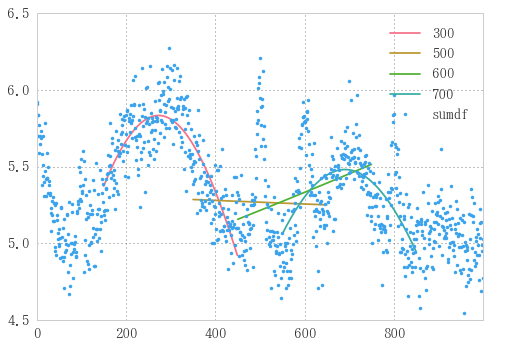

In [323]:
fitdf['sumdf'] = sumdf
fitdf.plot(style = ['-', '-', '-', '-', '.'])

In [152]:
fit=lambda df: curve_fit(gauss, x[:-1], df['0.0'], p0=(a, mu, si))

In [231]:
sumdf.apply(fit)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [211]:
Bfit = noisedf.T
Bfit.index=pd.date_range('20161111', freq='H', periods=10)
Bfit

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2016-11-11 00:00:00,1.212010,1.258258,1.209776,1.288453,1.312047,1.208359,1.235260,1.076348,1.234967,1.137405,...,0.514774,0.428211,0.598484,0.522549,0.519271,0.520157,0.412700,0.448095,0.461003,0.485658
2016-11-11 01:00:00,0.493312,0.565844,0.421950,0.566338,0.429704,0.490249,0.477613,0.543168,0.509640,0.466321,...,0.429264,0.449661,0.472302,0.450089,0.532711,0.497850,0.444576,0.510375,0.542243,0.559332
2016-11-11 02:00:00,0.617668,0.504491,0.506655,0.629424,0.459623,0.550356,0.552120,0.517778,0.474713,0.492209,...,0.459309,0.579805,0.506900,0.461104,0.452450,0.535329,0.465263,0.535872,0.549523,0.442362
2016-11-11 03:00:00,0.534732,0.434818,0.452569,0.429995,0.550611,0.552787,0.470041,0.503814,0.536437,0.526805,...,0.507729,0.510552,0.523317,0.480549,0.537138,0.477658,0.510539,0.461372,0.454722,0.471645
2016-11-11 04:00:00,0.410273,0.480496,0.535665,0.476028,0.496251,0.497739,0.532563,0.579697,0.466402,0.458867,...,0.452442,0.539615,0.476664,0.465095,0.469500,0.567530,0.465824,0.543424,0.524870,0.597768
2016-11-11 05:00:00,0.504844,0.585218,0.436708,0.510879,0.534301,0.533283,0.486974,0.505978,0.457899,0.416528,...,0.512470,0.516137,0.471788,0.485482,0.477160,0.424786,0.461915,0.421985,0.521713,0.534520
2016-11-11 06:00:00,0.417943,0.510378,0.561102,0.473348,0.547520,0.501062,0.538977,0.506837,0.576644,0.429382,...,0.538923,0.543066,0.634124,0.437527,0.546653,0.428585,0.503116,0.488980,0.513469,0.465994
2016-11-11 07:00:00,0.456581,0.578147,0.534539,0.437597,0.494838,0.445275,0.459347,0.466767,0.550208,0.408358,...,0.596552,0.572876,0.421376,0.626990,0.540775,0.502943,0.534820,0.420050,0.515703,0.511490
2016-11-11 08:00:00,0.487674,0.527124,0.462124,0.519189,0.478155,0.535298,0.458398,0.579006,0.470864,0.533235,...,0.572156,0.622233,0.477770,0.568988,0.541956,0.573163,0.493426,0.543387,0.540880,0.535761
2016-11-11 09:00:00,0.499399,0.443160,0.370964,0.410643,0.460746,0.571716,0.487904,0.524689,0.585601,0.635540,...,0.421390,0.476703,0.492336,0.474076,0.417654,0.580822,0.522962,0.434270,0.505289,0.437671


実際fittingかけたいデータフレームはindexが時間、カラムが